In [1]:
import keras
import numpy as np
from os import path, listdir
from os.path import isfile, join
from PIL import Image
from keras.models import Model
import tensorflow as tf
import matplotlib.pyplot as plt
import keras.initializers

from sklearn.model_selection import LeaveOneOut
import cv2
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import Normalizer

from tensorflow.keras import backend as K
from tensorflow.keras import models

Using TensorFlow backend.


In [2]:
IMAGE_SIZE = (152, 152) # set by the model
CHANNELS = 3 # RGB image
NUM_CLASSES = 8631 # classification layer will be removed
LEARN_RATE = 0.01
MOMENTUM = 0.9

DOWNLOAD_PATH = 'https://github.com/swghosh/DeepFace/releases/download/weights-vggface2-2d-aligned/VGGFace2_DeepFace_weights_val-0.9034.h5.zip'
MD5_HASH = '0b21fb70cd6901c96c19ac14c9ea8b89'

In [3]:
wt_init = tf.random_normal_initializer(mean=0, stddev=0.01)
bias_init = tf.constant_initializer(value=0.5)

In [4]:
def create_classifying_deepface(image_size=IMAGE_SIZE, channels=CHANNELS, num_classes=NUM_CLASSES, learn_rate=LEARN_RATE, momentum=MOMENTUM):
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(*image_size, channels), name='I0'))
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=11, activation=tf.nn.relu, kernel_initializer=wt_init, bias_initializer=bias_init, name='C1'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2, padding='same', name='M2'))
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=9, activation=tf.nn.relu, kernel_initializer=wt_init, bias_initializer=bias_init, name='C3'))
    model.add(tf.keras.layers.LocallyConnected2D(filters=16, kernel_size=9, activation=tf.nn.relu, kernel_initializer=wt_init, bias_initializer=bias_init, name='L4'))
    model.add(tf.keras.layers.LocallyConnected2D(filters=16, kernel_size=7, strides=2,  activation=tf.nn.relu, kernel_initializer=wt_init, bias_initializer=bias_init, name='L5'))
    model.add(tf.keras.layers.LocallyConnected2D(filters=16, kernel_size=5, activation=tf.nn.relu, kernel_initializer=wt_init, bias_initializer=bias_init, name='L6'))
    model.add(tf.keras.layers.Flatten(name='F7'))
    model.add(tf.keras.layers.Dense(units=4096, activation=tf.nn.relu, kernel_initializer=wt_init, bias_initializer=bias_init, name='F8'))
    model.add(tf.keras.layers.Dropout(rate=0.5, name='D9'))
    model.add(tf.keras.layers.Dense(units=num_classes, activation=tf.nn.softmax, kernel_initializer=wt_init, bias_initializer=bias_init, name='F10'))

    sgd_opt = tf.keras.optimizers.SGD(learning_rate=learn_rate, momentum=momentum)
    cce_loss = tf.keras.losses.CategoricalCrossentropy()

    model.compile(optimizer=sgd_opt, loss=cce_loss, metrics=['acc'])
    weights = get_weights()
    model.load_weights(weights)

    return model

In [16]:
def get_weights():
    filename = 'deepface.zip'
    downloaded_file_path = keras.utils.get_file(filename, DOWNLOAD_PATH,
        md5_hash=MD5_HASH, extract=True)
    downloaded_h5_file = path.join(path.dirname(downloaded_file_path),
        path.basename(DOWNLOAD_PATH).rstrip('.zip'))
    return downloaded_h5_file


def create_deepface():
    model = create_classifying_deepface()
    
#     model2 = tf.keras.Sequential()

#     # remove last dropout layer and dense layer
#     for layer in model.layers[:-2]:
#         model2.add(layer)

#     sgd_opt = tf.keras.optimizers.SGD(learning_rate=LEARN_RATE, momentum=MOMENTUM)
#     cce_loss = tf.keras.losses.CategoricalCrossentropy()

#     model2.compile(optimizer=sgd_opt, loss=cce_loss, metrics=['acc'])
#     model2.build((None, *IMAGE_SIZE, CHANNELS))
    return model

In [17]:
model  = create_deepface()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv2D)                  (None, 142, 142, 32)      11648     
_________________________________________________________________
M2 (MaxPooling2D)            (None, 71, 71, 32)        0         
_________________________________________________________________
C3 (Conv2D)                  (None, 63, 63, 16)        41488     
_________________________________________________________________
L4 (LocallyConnected2D)      (None, 55, 55, 16)        62774800  
_________________________________________________________________
L5 (LocallyConnected2D)      (None, 25, 25, 16)        7850000   
_________________________________________________________________
L6 (LocallyConnected2D)      (None, 21, 21, 16)        2829456   
_________________________________________________________________
F7 (Flatten)                 (None, 7056)             

In [18]:
path_patient = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\ADNP\ADNP-patients"
patients = [join(path_patient, f) for f in listdir(path_patient)]
#patients = [patients[0]]

path_control = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\ADNP\ADNP-selected-ID-controls"
controls = [join(path_control, f) for f in listdir(path_control)]
#controls = [controls[0]]

0
(351, 272, 3)
(1, 63, 63)
(1, 55, 55)
(1, 25, 25)
(1, 21, 21)
(1000, 750, 3)
(1, 63, 63)
(1, 55, 55)
(1, 25, 25)
(1, 21, 21)


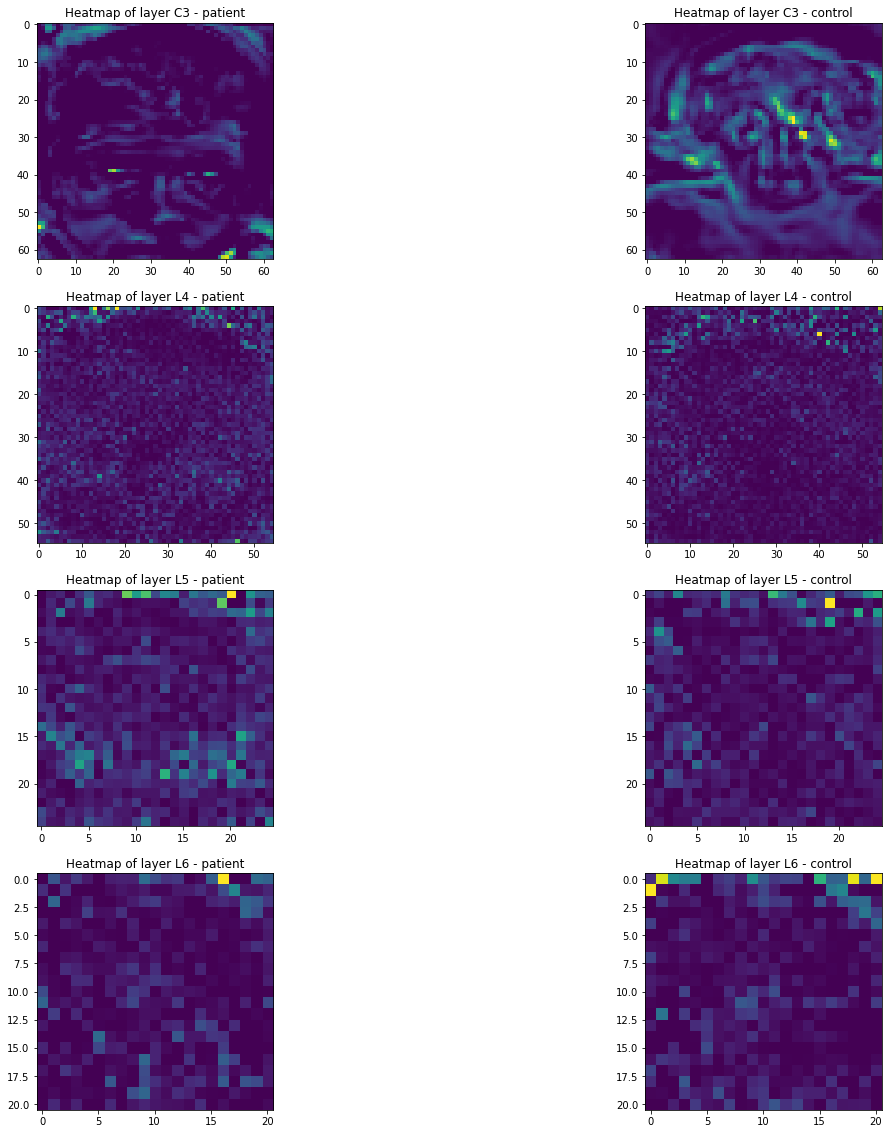

In [26]:
layers = ["C3", "L4", "L5", "L6"]
img_name = ["patient", "control"]

for index in range(len(patients)):
    patient = [patients[index]]
    control = [controls[index]]
    
    fig = plt.figure(figsize=(18, 18))
    columns = 2
    rows = len(layers)*len(patient)
    
    for i, img_file in enumerate(patient+control):

        img = cv2.imread(img_file)
        img = cv2.resize(img, (IMAGE_SIZE))               
        img_tensor = np.expand_dims(img, axis=0)
        
        for l, name in enumerate(layers): 

            conv_layer = model.get_layer(name)

            heatmap_model = models.Model([model.inputs], [conv_layer.output, model.output])

            # Get gradient of the winner class w.r.t. the output of the (last) conv. layer
            with tf.GradientTape() as gtape:
                conv_output, predictions = heatmap_model(img_tensor)
                loss = predictions[:, np.argmax(predictions[0])]
                grads = gtape.gradient(loss, conv_output)
                pooled_grads = K.mean(grads, axis=(0, 1, 2))

            heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
            heatmap = np.maximum(heatmap, 0)
            max_heat = np.max(heatmap)
            if max_heat == 0:
                max_heat = 1e-10
            heatmap /= max_heat
            print(heatmap.shape)
            heatmap = np.squeeze(heatmap)

            nr = l * 2 + i + 1
            fig.add_subplot(rows, columns, nr)
            plt.imshow(heatmap)
            plt.title("Heatmap of layer {} - {}".format(name, img_name[i]))
    plt.show()
    break